In [1]:
import gymnasium as gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm
import random
from tqdm import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## OpenAI Gym

In [2]:
env = gym.make('FrozenLake-v1', render_mode="ansi")
env.reset();
for _ in range(5):
    print(env.render())
    env.step(env.action_space.sample()) # take a random action
env.close()


SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG



## TD-обучение: on-policy (Sarsa)

## SARSA (on-policy TD control) для оценки Q ≈ q\*

**Инициализировать** Q(s, a) для всех s ∈ S, a ∈ A(s) произвольными значениями,  
и установить Q(terminal-state, ·) = 0

**Повторять** (для каждого эпизода):
- Инициализировать состояние **S**
- Выбрать **A** из **S** согласно политике, основанной на **Q**  
  *(например, ε-жадная)*

    **Повторять** (для каждого шага эпизода):
    - Совершить действие **A**, получить вознаграждение **R**, новое состояние **S′**
    - Выбрать **A′** из **S′** согласно политике, основанной на **Q**  
      *(например, ε-жадная)*
    - Обновить значение:
      ```
      Q(S, A) ← Q(S, A) + α [ R + γ · Q(S′, A′) − Q(S, A) ]
      ```
    - S ← S′  
    - A ← A′

**Пока S не станет терминальным**


**Ключевые особенности:**

- 🧠 *On-policy*: обучение и действия следуют одной стратегии (в отличие от Q-learning)
- 🔁 Используется TD (Temporal Difference) обновление
- 📉 Q(S, A) постепенно приближается к оптимальному **q\*(s, a)**



==============================================================

In [6]:
# создаем Q таблицу - размер S на A

nS, nA = env.observation_space.n, env.action_space.n
nS, nA

(16, 4)

In [8]:
# Терминальные ячейки
final_states = np.where([ len(env.unwrapped.P[x][0]) == 1 and env.unwrapped.P[x][0][0][3] == True for x in env.unwrapped.P.keys() ])[0]
final_states

array([ 5,  7, 11, 12, 15], dtype=int64)

In [11]:
def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

def compute_policy_by_Q(env, Q):
    return np.argmax(Q, axis=1)

In [12]:
get_random_Q(env)

array([[0.90677962, 0.38614503, 0.61987432, 0.25923584],
       [0.55821038, 0.74768344, 0.19598727, 0.30806183],
       [0.51240009, 0.47203634, 0.31593562, 0.20792034],
       [0.42110156, 0.75895639, 0.83576448, 0.80314597],
       [0.59448278, 0.51939323, 0.93089945, 0.97216492],
       [0.        , 0.        , 0.        , 0.        ],
       [0.46596464, 0.34991324, 0.45416409, 0.02828881],
       [0.        , 0.        , 0.        , 0.        ],
       [0.03298795, 0.15144246, 0.88489085, 0.5832634 ],
       [0.4228395 , 0.40710472, 0.37085717, 0.27125755],
       [0.73979836, 0.62924325, 0.70732811, 0.63765537],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.69705582, 0.55558742, 0.08470409, 0.53114617],
       [0.52672296, 0.49826035, 0.01947095, 0.96586205],
       [0.        , 0.        , 0.        , 0.        ]])

In [17]:
def Sarsa_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    """
    Один эпизод обучения с использованием SARSA (on-policy) алгоритма.
    """
    env.reset()
    s, a = env.unwrapped.s, pi[env.unwrapped.s] if np.random.rand() > epsilon else np.random.randint(nA)
    while True:
        observation, reward, terminated, truncated, info = env.step(a)
        s_prime, a_prime = env.unwrapped.s, pi[env.unwrapped.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * Q[s_prime][a_prime] - Q[s][a])
        s, a = s_prime, a_prime
        if terminated or truncated:
            break

In [21]:
env = gym.make('FrozenLake-v1', render_mode="ansi")
env._max_episode_steps = 10000  # Увеличение максимальной длины эпизода

total_episodes = 20000
gamma = 0.9

Q_hist_Sarsa = []  # История Q-таблиц на протяжении обучения

Q = get_random_Q(env)  # Инициализация Q-таблицы случайными значениями
pi = compute_policy_by_Q(env, Q)  # Получение начальной policy по Q

# Цикл обучения с использованием SARSA
for n in tqdm(range(1, total_episodes + 1)):
    Sarsa_learning_episode(env, pi, Q, alpha=0.1, epsilon=1. / (np.log(n) + 1), gamma=gamma)  # Один эпизод SARSA
    pi = compute_policy_by_Q(env, Q)  # Обновление policy после эпизода
    Q_hist_Sarsa.append(np.copy(Q))  # Сохранение текущей Q-таблицы

env.close()


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4387.26it/s]


In [22]:
print(env.render())

  (Down)
SFFF
FHFH
FFFH
HFFG



In [23]:
#print("Лучшая стратегия:\n%s" % np.reshape(pi_max, (4, 4)))
print("Текущая стратегия:\n%s" % np.reshape(pi, (4, 4)))

Текущая стратегия:
[[0 3 1 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 1 0]]


In [12]:
np.set_printoptions(precision=6, suppress=True)
print("Полученная функция Q:\n%s" % (np.array(Q)))

Полученная функция Q:
[[0.047471 0.053183 0.049993 0.04233 ]
 [0.036652 0.034848 0.045779 0.049608]
 [0.06927  0.055787 0.046127 0.039375]
 [0.018564 0.03022  0.01692  0.043229]
 [0.078452 0.040969 0.048228 0.030051]
 [0.       0.       0.       0.      ]
 [0.122065 0.045157 0.048628 0.005952]
 [0.       0.       0.       0.      ]
 [0.052579 0.077629 0.073756 0.122991]
 [0.157576 0.200352 0.175991 0.133972]
 [0.27487  0.182416 0.173091 0.106941]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.167621 0.234899 0.337392 0.227034]
 [0.316021 0.481343 0.647776 0.439008]
 [0.       0.       0.       0.      ]]


In [26]:
# Функция оценивает качество стратегии (policy) pi в среде env
# Проводится num_experiments эпизодов (по умолчанию 1000), в каждом — запуск стратегии до завершения
# Возвращаются средние значения: награда (reward) и количество шагов (steps) до завершения

def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []  # списки для хранения количества шагов и суммарной награды в каждом эпизоде
    for _ in range(num_experiments):  # повторяем num_experiments раз
        env.reset()  # начинаем новый эпизод
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):  # ограничение на количество шагов в эпизоде
            # выбираем действие из стратегии pi, используя текущее состояние среды
            observation, reward, terminated, truncated, info = env.step(pi[env.unwrapped.s])
            total_reward[-1] += reward  # накапливаем награду
            num_steps[-1] += 1  # считаем шаг
            if terminated:  # если достигнуто финальное состояние — выходим
                break
    env.close()  # закрываем среду после всех экспериментов
    return np.mean(total_reward), np.mean(num_steps)  # возвращаем средние значения по всем эпизодам


In [30]:
"""
Протестируем, насколько хорошо работают стратегии и насколько быстро они обучаются
Выполняется total_episodes (1000) эпизодов
В каждом эпизоде участвуют 10 стратегий (агентов), каждая со своей Q-функцией
После каждого эпизода пересчитываются стратегии (policy) и
их качество проверяется на 50 дополнительных эпизодах (num_experiments_pi)
Оценка проводится по среднему значению награды и количеству шагов до цели
"""

env = gym.make('FrozenLake-v1', render_mode="ansi")  # создаём среду FrozenLake с текстовым выводом
env._max_episode_steps = 10000  # увеличиваем максимально допустимое количество шагов в эпизоде

num_experiments, num_experiments_pi = 10, 50  # количество стратегий (агентов) и экспериментов на проверку

total_episodes = 10000  # общее количество эпизодов обучения
gamma = 0.9  # коэффициент дисконтирования (discount factor)

results_sarsa = []  # здесь будут сохраняться результаты для каждой итерации

# Инициализируем массив Q-функций случайными значениями для каждого агента
Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
# Строим начальные стратегии (policy) на основе Q-функций
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

# Основной цикл обучения по методу SARSA
for n in tqdm(range(1, total_episodes+1)):
    # Один обучающий эпизод SARSA для каждой стратегии, с обновлением Q-функции
    _ = [ Sarsa_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.01, epsilon= 1. / (np.log(n)+1) , gamma=gamma) for i in range(num_experiments) ]
    # Перестраиваем стратегии на основе обновлённых Q-функций
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    # Тестируем стратегии: по 50 эпизодов на каждую, сохраняем среднюю награду и число шагов
    result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
    results_sarsa.append([ [x[0], x[1]] for x in result ])  # сохраняем результаты

env.close()  # закрываем среду


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [18:34<00:00,  8.97it/s]


Text(0.5, 0, 'Эпизоды')

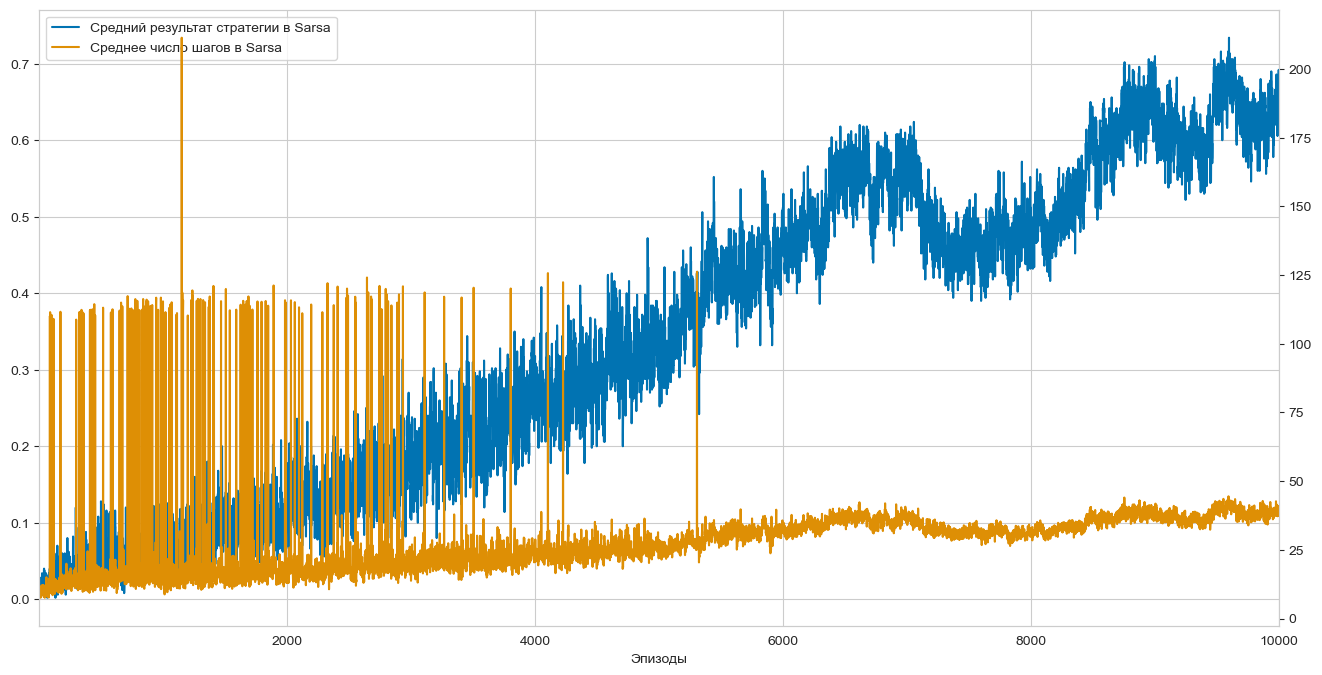

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns = np.mean( np.array([ [x[0] for x in res] for res in results_sarsa]), axis=1)
avg_steps = np.mean( np.array([ [x[1] for x in res] for res in results_sarsa]), axis=1)

line1 = ax.plot(np.arange(1, total_episodes+1), avg_returns, label="Средний результат стратегии в Sarsa", color="C0")
line2 = ax2.plot(np.arange(1, total_episodes+1), avg_steps, label="Среднее число шагов в Sarsa", color="C1")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)
# ax.set_xlim((0.5, 1.0))
# ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")

## TD-обучение: off-policy (Q-обучение)

### Q-learning (off-policy TD control) для оценки π ≈ π*

1. **Инициализация:**  
   Задать произвольные значения `Q(s, a)` для всех `s ∈ S`, `a ∈ A(s)`  
   Установить `Q(terminal-state, ·) = 0`

2. **Повторять (для каждого эпизода):**  
   - Инициализировать начальное состояние `S`
   - **Повторять (для каждого шага эпизода):**
     - Выбрать `A` из `S` по политике, основанной на `Q` (например, ε-жадная)
     - Совершить действие `A`, получить награду `R` и новое состояние `S′`
     - Обновить:
       ```
       Q(S, A) ← Q(S, A) + α · [R + γ · max_a Q(S′, a) − Q(S, A)]
       ```
     - `S ← S′`
   - Пока `S` не терминально


![](https://habrastorage.org/webt/wf/6x/fi/wf6xfiyazgu0echvfsw8d9-oly4.png)

In [38]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    """
    Эпизод обучения по алгоритму Q-learning.

    Обновляет Q-функцию, проходя один эпизод в среде.
    Используется стратегия pi как базовая, но с вероятностью epsilon агент выбирает случайное действие (exploration).
    
    На каждом шаге:
    - Агент выполняет действие a и получает (reward) и новое состояние s'
    - Q-функция обновляется по формуле с учетом максимального Q в следующем состоянии (greedy-оценка)
    - Эпизод завершается, если достигнуто терминальное состояние (terminated)

    Параметры:
    - alpha: скорость обучения
    - epsilon: вероятность случайного действия (исследование)
    - gamma: коэффициент дисконтирования
    """
    env.reset()
    s, a = env.unwrapped.s, pi[env.unwrapped.s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, terminated, truncated, info = env.step(a)
        s_prime, a_prime = env.unwrapped.s, pi[env.unwrapped.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if terminated:
            break


In [39]:
env = gym.make('FrozenLake-v1', render_mode="ansi")
env._max_episode_steps = 10000
total_episodes = 15000
gamma = 0.9


Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in tqdm(range(total_episodes)):
    Q_learning_episode(env, pi, Q, alpha=0.1, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:04<00:00, 3271.24it/s]


In [40]:
print(env.render())

  (Down)
SFFF
FHFH
FFFH
HFFG



In [41]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [42]:
print("Текущая стратегия:\n%s" % np.reshape(pi, (4, 4)))

Текущая стратегия:
[[2 3 0 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 1 0]]


In [43]:
np.set_printoptions(precision=6, suppress=True)
print("Полученная функция Q:\n%s" % (np.array(Q)))

Полученная функция Q:
[[0.071979 0.071638 0.072542 0.068084]
 [0.041614 0.029808 0.046526 0.065924]
 [0.072932 0.0658   0.067316 0.058246]
 [0.036513 0.030181 0.028932 0.058503]
 [0.095739 0.074639 0.065957 0.046429]
 [0.       0.       0.       0.      ]
 [0.077662 0.037228 0.074781 0.00977 ]
 [0.       0.       0.       0.      ]
 [0.070802 0.139316 0.086172 0.132838]
 [0.097787 0.285182 0.229474 0.150594]
 [0.40426  0.258216 0.336416 0.131442]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.24899  0.280683 0.42513  0.353825]
 [0.406161 0.664407 0.572853 0.528502]
 [0.       0.       0.       0.      ]]


In [44]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
env = gym.make('FrozenLake-v1', render_mode="ansi")
env._max_episode_steps = 10000

num_experiments, num_experiments_pi = 10, 50

total_episodes = 10000
gamma = 0.9

results_Qlearn = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    _ = [ Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.01, epsilon= 1. / (np.log(n)+1), gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
    results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [20:18<00:00,  8.21it/s]


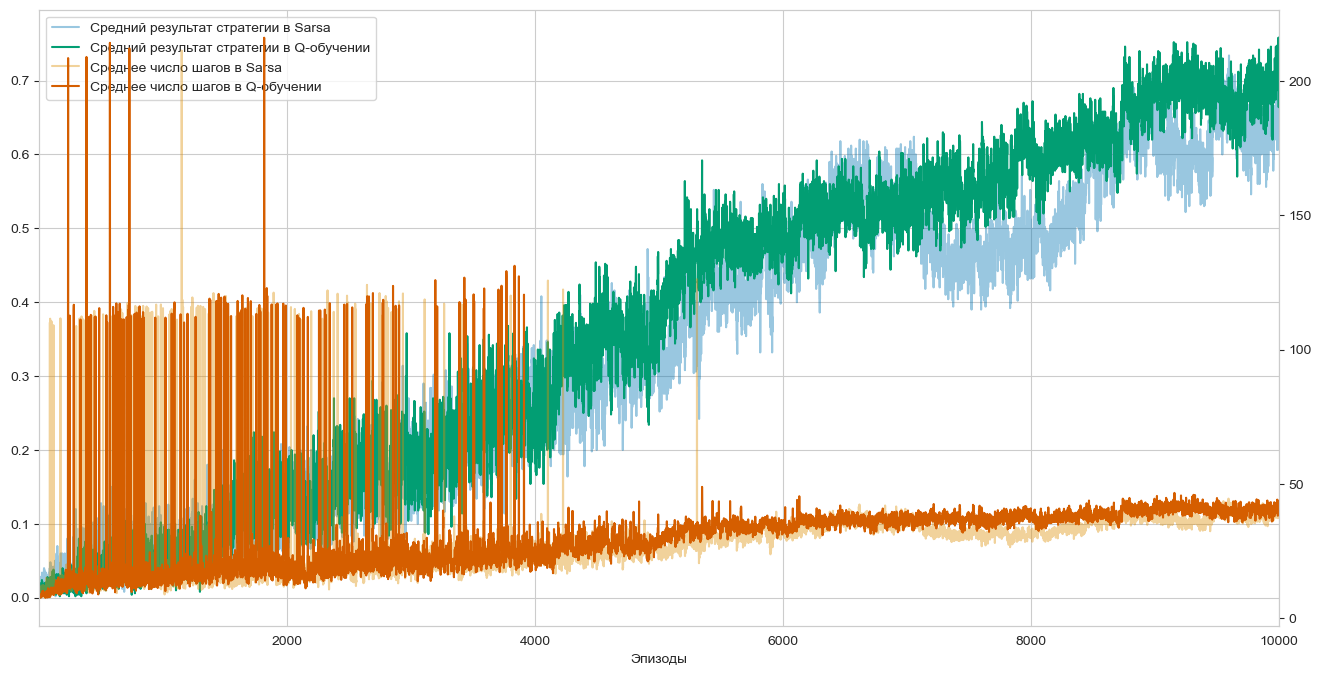

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line1 = ax.plot(np.arange(1, total_episodes+1), avg_returns, label="Средний результат стратегии в Sarsa", color="C0", alpha=0.4)
line2 = ax2.plot(np.arange(1, total_episodes+1), avg_steps, label="Среднее число шагов в Sarsa", color="C1", alpha=0.4)
line3 = ax.plot(np.arange(1, total_episodes+1), avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line4 = ax2.plot(np.arange(1, total_episodes+1), avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line1 + line3 + line2 + line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды");